In [71]:
import os
import json
import numpy as np
from PIL import Image
import boto3
import time
import cv2
import urllib
import sys
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError
import sagemaker
import re
from sagemaker import get_execution_role, session, ModelPackage

In [17]:
region = boto3.Session().region_name
role = get_execution_role()

In [ ]:
## We have images in local directory we first upload them to s3 bucket

In [35]:
def convert_images_to_jsonl(input_dir, max_image_size=(512, 512), bucket_name=None, s3_output_key=None): 
    jsonl_data = []
    s3 = boto3.client('s3')

    for img_file in os.listdir(input_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):  
            print(f"Processing image {img_file}")
            img_path = os.path.join(input_dir, img_file)
            img = Image.open(img_path)
            #img.thumbnail(max_image_size)
            if bucket_name and s3_output_key:
                s3 = boto3.client('s3')
                s3.upload_file(img_path, bucket_name, s3_output_key+f"/{img_file}")
                print(f"Image file uploaded to s3://{bucket_name}/{s3_output_key}/{img_file}")


In [36]:
convert_images_to_jsonl('../test_imgs/', bucket_name='sagemaker-us-east-1-470086202700', s3_output_key='balloon_segemtaion_model/input/images')

Processing image 16335852991_f55de7958d_k.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/images/16335852991_f55de7958d_k.jpg
Processing image 8053085540_a72bd21a64_k.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/images/8053085540_a72bd21a64_k.jpg
Processing image 6810773040_3d81036d05_k.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/images/6810773040_3d81036d05_k.jpg
Processing image 4838031651_3e7b5ea5c7_b.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/images/4838031651_3e7b5ea5c7_b.jpg
Processing image 5603212091_2dfe16ea72_b.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/images/5603212091_2dfe16ea72_b.jpg
Processing image 410488422_5f8991f26e_b.jpg
Image file uploaded to s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/im

In [59]:
sagemaker_session=sagemaker.Session(default_bucket="sagemaker-us-east-1-470086202700")

In [60]:
model_package_arn='arn:aws:sagemaker:us-east-1:470086202700:model-package/balloon-segemntation-nonprod-group/12'

In [61]:
model = ModelPackage(role=role, 
                     model_package_arn=model_package_arn, 
                     sagemaker_session=sagemaker_session)

In [62]:
model_outputs_path="s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/output"

In [63]:
transformer=model.transformer(instance_count=1, instance_type="ml.p3.2xlarge", output_path=model_outputs_path,
                             max_payload=100)

INFO:sagemaker:Creating model with name: balloon-segemntation-nonprod-group-2024-09-10-17-58-42-434


In [64]:
transformer.transform(
    data='s3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/', 
    data_type="S3Prefix",
    content_type="application/x-image",
    wait=True
)

INFO:sagemaker:Creating transform job with name: balloon-segemntation-nonprod-group-2024-09-10-17-58-50-214


..................................................................................Starting the inference server with 1 workers.
[2024-09-10 18:12:35 +0000] [10] [INFO] Starting gunicorn 20.1.0
[2024-09-10 18:12:35 +0000] [10] [INFO] Listening at: unix:/tmp/gunicorn.sock (10)
[2024-09-10 18:12:35 +0000] [10] [INFO] Using worker: gevent
[2024-09-10 18:12:35 +0000] [12] [INFO] Booting worker with pid: 12
The Model Weights path exists? True
The Config path exists? True
Initializing the model for Inference!!
169.254.255.130 - - [10/Sep/2024:18:12:41 +0000] "GET /ping HTTP/1.1" 200 38 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Sep/2024:18:12:41 +0000] "GET /ping HTTP/1.1" 200 38 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Sep/2024:18:12:41 +0000] "GET /execution-parameters HTTP/1.1" 404 2 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Sep/2024:18:12:41 +0000] "GET /execution-parameters HTTP/1.1" 404 2 "-" "Go-http-client/1.1"
Running Inference!!
Running Inference!!
/usr/local/li

In [70]:
## Get Results

In [66]:
sm_cli = sagemaker_session.sagemaker_client

In [67]:
job_info = sm_cli.describe_transform_job(
    TransformJobName=transformer.latest_transform_job.name
)

job_info

{'TransformJobName': 'balloon-segemntation-nonprod-group-2024-09-10-17-58-50-214',
 'TransformJobArn': 'arn:aws:sagemaker:us-east-1:470086202700:transform-job/balloon-segemntation-nonprod-group-2024-09-10-17-58-50-214',
 'TransformJobStatus': 'Completed',
 'ModelName': 'balloon-segemntation-nonprod-group-2024-09-10-17-58-42-434',
 'MaxPayloadInMB': 100,
 'TransformInput': {'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
    'S3Uri': 's3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/input/'}},
  'ContentType': 'application/x-image',
  'CompressionType': 'None',
  'SplitType': 'None'},
 'TransformOutput': {'S3OutputPath': 's3://sagemaker-us-east-1-470086202700/balloon_segemtaion_model/output',
  'AssembleWith': 'None',
  'KmsKeyId': ''},
 'TransformResources': {'InstanceType': 'ml.p3.2xlarge', 'InstanceCount': 1},
 'CreationTime': datetime.datetime(2024, 9, 10, 17, 58, 50, 433000, tzinfo=tzlocal()),
 'TransformStartTime': datetime.datetime(2024, 9, 10, 18, 4, 10, 

In [76]:
def get_bucket_and_prefix(s3_output_path):
    trim = re.sub("s3://", "", s3_output_path)
    splitted=trim.split("/")
    bucket = splitted[0]
    prefix="/".join(splitted[1:])
    return bucket, prefix


local_path = "output"  # Where to save the output locally

bucket, output_prefix = get_bucket_and_prefix(job_info["TransformOutput"]["S3OutputPath"])
print(bucket, output_prefix)

sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=output_prefix)

sagemaker-us-east-1-470086202700 balloon_segemtaion_model/output


['output/images/14898532020_ba6199dd22_k.jpg.out',
 'output/images/16335852991_f55de7958d_k.jpg.out',
 'output/images/24631331976_defa3bb61f_k.jpg.out',
 'output/images/2917282960_06beee649a_b.jpg.out',
 'output/images/3800636873_ace2c2795f_b.jpg.out',
 'output/images/3825919971_93fb1ec581_b.jpg.out',
 'output/images/410488422_5f8991f26e_b.jpg.out',
 'output/images/4581425993_72b9b15fc0_b.jpg.out',
 'output/images/4838031651_3e7b5ea5c7_b.jpg.out',
 'output/images/5555705118_3390d70abe_b.jpg.out',
 'output/images/5603212091_2dfe16ea72_b.jpg.out',
 'output/images/6810773040_3d81036d05_k.jpg.out',
 'output/images/8053085540_a72bd21a64_k.jpg.out',
 'output/images/input.jpg.out',
 'output/input_imgs.jsonl.out']

In [84]:
def rle_decode(rle, shape):
    rle = np.array(rle).reshape(-1, 2)
    run_lengths = rle[:, 0]
    run_values = rle[:, 1]
    pixels = np.repeat(run_values, run_lengths)
    return pixels.reshape(shape)

In [85]:
def visualize_masks(masks,img):
    """Apply the masks to the image."""
    vis_img=img.copy()
    from random import randint
    for i in range(masks.shape[0]):
        color = [randint(0, 255) for p in range(3)]
        for j in range(3):
            vis_img[:, :,j] = np.where(masks[i] != 0,color[j],vis_img[:,:,j])
    return vis_img

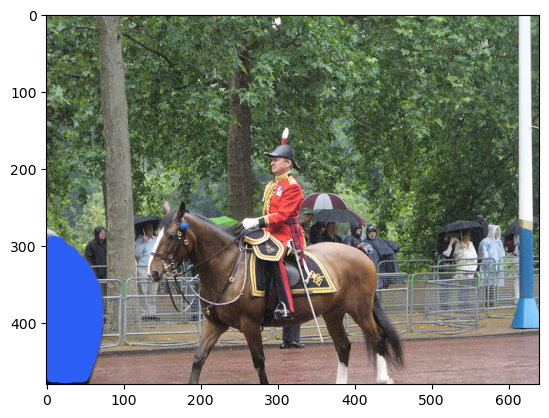

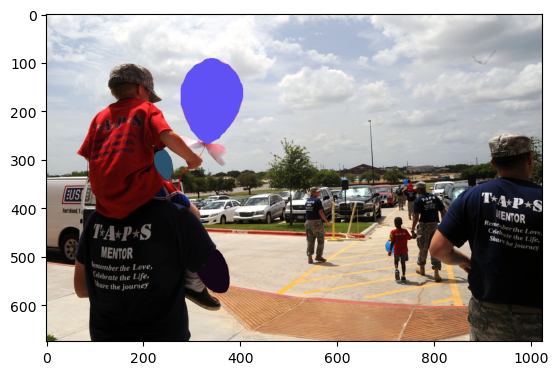

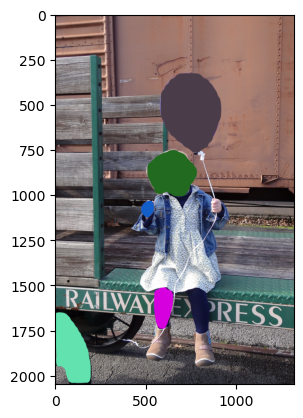

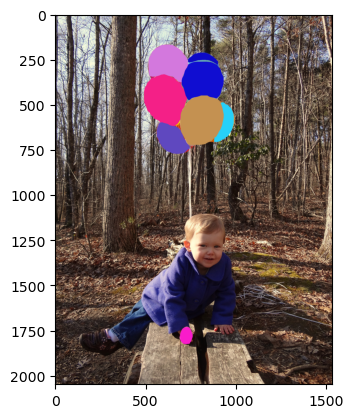

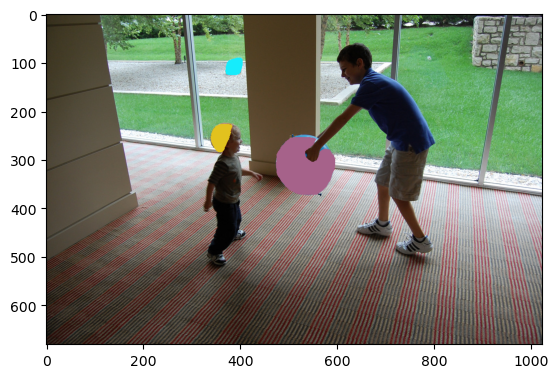

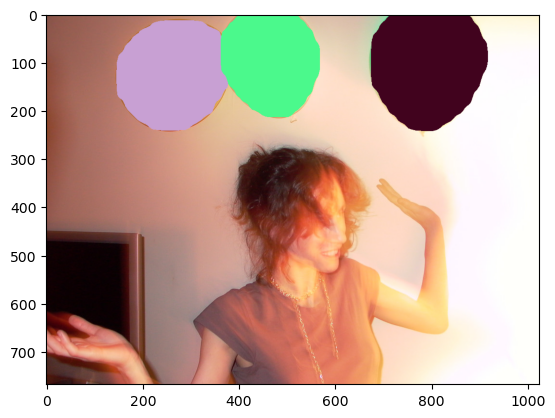

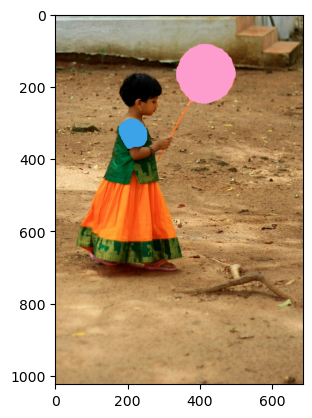

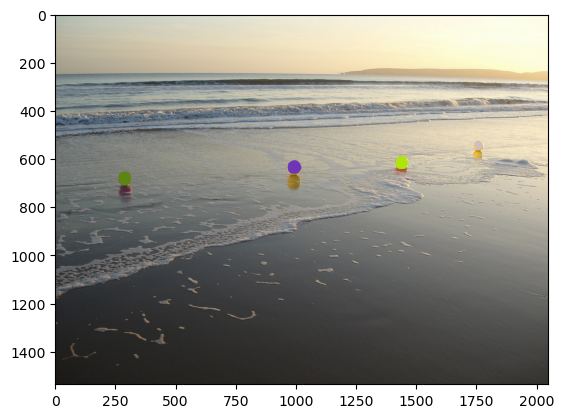

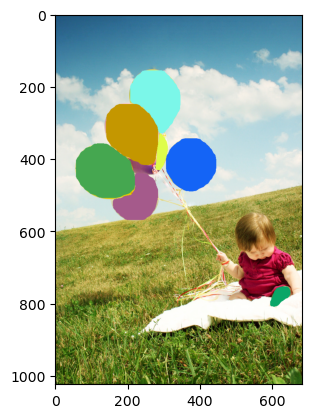

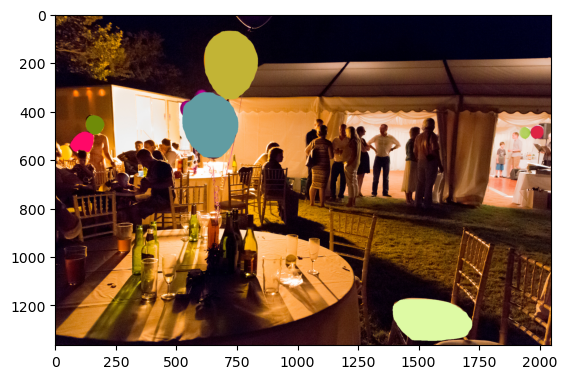

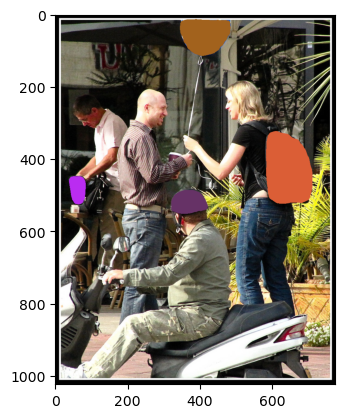

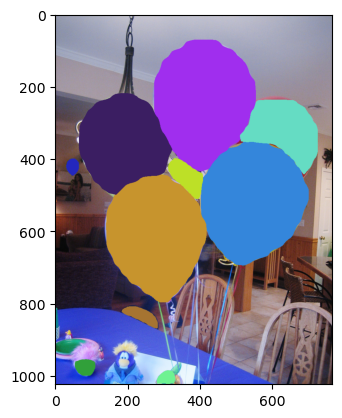

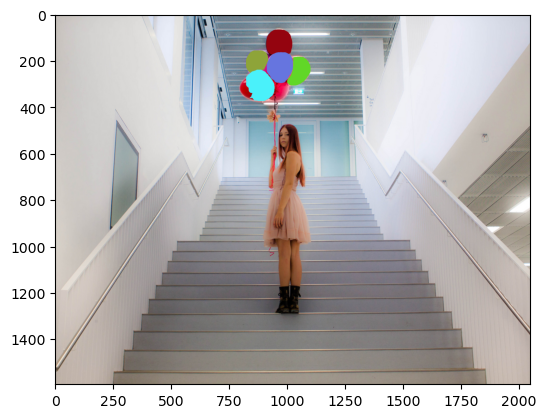

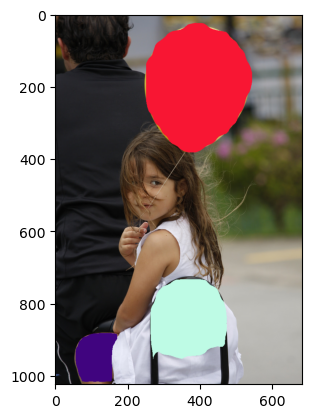

In [90]:
f_path=f"{local_path}/images"
imgs_path="../test_imgs"
for f in os.listdir(f_path):
    img_path=os.path.join(imgs_path,f[:-4])
    img=cv2.imread(img_path)
    full_path=os.path.join(f_path,f)
    with open(os.path.join(f_path,f),'r') as d_f:
        res=json.loads(d_f.read())
    rle_masks=res["masks"]
    masks_shape= res["mask_shape"]
    masks=np.array([rle_decode(rle,masks_shape) for rle in rle_masks ])
    boxes=np.array(res["boxes"])
    classes=np.array(res["classes"])
    detected_masks=visualize_masks(masks,img)
    plt.figure()
    plt.imshow(detected_masks[...,::-1])